# Seismic velocity variations at station PATCX, Northern Chile

This notebook is a showcase for the [yam](https://github.com/trichter/yam) package and tries to reproduce some results of the following publications:

[1] Richter et al. (2014), Comprehensive observation and modeling of earthquake and temperature related seismic velocity changes in northern Chile with passive image interferometry, *Journal of Geophysical Research* [doi](http://dx.doi.org/10.1002/2013JB010695) [pdf](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:823917:4/component/escidoc:828895/823917.pdf)

[2] Gassenmeier et al. (2016), Field observations of seismic velocity changes caused by shaking-induced damage and healing due to mesoscopic nonlinearity, *Geophysical Journal International* [doi](https://doi.org/10.1093/gji/ggv529) [pdf](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:1649891:4/component/escidoc:1661892/1649891.pdf)

Both publications analyze velocity variations at the Chilean seismic station PATCX, located in the Atacama desert. This station is part of the *Integrated Plate Boundary Observatory Chile* ([IPOC](http://www.ipoc-network.org)) and shows a high sensitivity of seismic velocity changes towards temperature changes and shaking.

If you want to run this notebook locally, have a look at the repository [readme](https://github.com/trichter/notebooks). `yam` needs to be installed.

### Downloading data

First we import some functions, define the time window to investigate and download 1 year of data of the Z component with ObsPy's mass downloader.

In [1]:
from IPython.display import Image
import tqdm

from obspy import read, read_inventory, Stream, UTCDateTime as UTC
from yam import read_dicts
from yam.imaging import plot_sim_mat
from yam.stretch import stretch
from yam.util import IterTime

starttime = UTC('2013-03-01')
endtime = UTC('2014-03-01')

In [2]:
from obspy.clients.fdsn.mass_downloader import (
    GlobalDomain, Restrictions, MassDownloader)

domain = GlobalDomain()
restrictions = Restrictions(
    starttime=starttime, endtime=endtime,
    network='CX', station='PATCX', location=None,
    channel_priorities=["HHZ"], chunklength_in_sec=86400,
    reject_channels_with_gaps=False, minimum_length=0.5)
mdl = MassDownloader(providers=['GFZ'])
mdl.download(domain, restrictions, 'day_files', '.')

### Configuration

yam is a python package and command line tool. Commands starting with `!` are executed on the shell command line. The configuration file is created in the following. We correlate in the frequency range 4 Hz to 6 Hz (same as in the publications). `"based_on"` option is used to employ the configuration of a specific key and just overwrite the specified values.

In [3]:
conf = """{
"io": {
        "inventory": "CX.PATCX.xml",
        "data": "day_files/{network}.{station}.{location}.{channel}__{t.year}{t.month:02d}{t.day:02d}*.mseed",
        "data_format": "MSEED",
        "corr": "corr.h5",
        "stack": "stack.h5",
        "stretch": "stretch.h5",
        "plot": "plots"
        },
"correlate": {
        "1": {  "startdate": "%s",
                "enddate": "%s",
                "length": 3600,
                "overlap": 1800,
                "discard": 0.8,
                "filter": [4, 6],
                "max_lag": 30,
                "normalization": ["mute_envelope", "1bit"],
                "keep_correlations": true,
                "stack": null
                },
        "1b": { "based_on": "1",
                "filter": [2, 4]
                },
        "1c": { "based_on": "1",
                "filter": [6, 8]
                }
        },
"stack": {
        "1": {  "length": "1d",
                "move": "12h"
                }
        },
"stretch": {
        "1": {  "str_range": 1.5,
                "nstr": 401,
                "time_windows": [[5, 10, 15], 5],
                "sides": "both"
                }
        }
}""" % (str(starttime)[:10], str(endtime)[:10])

with open('conf.json', 'w') as f:
    f.write(conf)

### Preprocessing

`yam info` displays an overview over the project status. Station meta data is loaded successfully and data files can be found. After that we have a look at the data for the first day. Preprocessing is defined in the correlation configuration. I chose `"mute_envelope"` to set times with high amplitude to zero and after that the well known `"1bit"` normalization. To check the preprocessing, prepared data of the first day is plotted afterwards. Everything works as expected: Preprocessed data consists only of 1, -1 and zeros at times with large amplitudes.

In [4]:
!yam info

Stations:
    CX.PATCX
    1 stations, 1 channels
Raw data (expression for day files):
    day_files/{network}.{station}.{location}.{channel}__{t.year}{t.month:02d}{t.day:02d}*.mseed
    365 files found
Config ids:
    c Corr: 1, 1b, 1c
    s Stack: 1
    t Stretch: 1
Correlations (channel combinations, correlations calculated):
    None
Stacks:
    None
Stretching matrices:
    None


/home/eule/anaconda/envs/workhorse/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


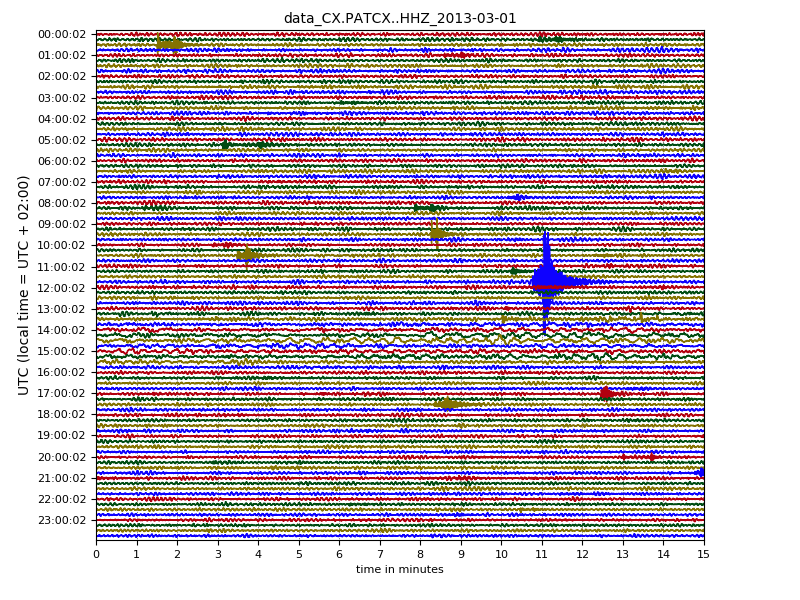

In [5]:
!yam plot data CX.PATCX..HHZ 2013-03-01
Image("plots/data_CX.PATCX..HHZ_2013-03-01.png", width=600)

/home/eule/anaconda/envs/workhorse/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


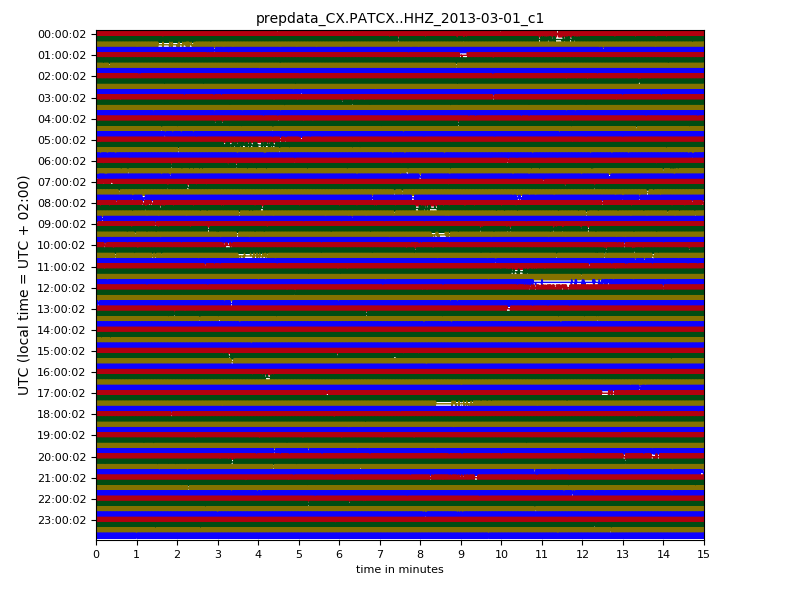

In [6]:
!yam plot prepdata CX.PATCX..HHZ 2013-03-01 1
Image("plots/prepdata_CX.PATCX..HHZ_2013-03-01_c1.png", width=600)

### Correlation and stacking

We start the correlation with the following simple command which uses the corresponding configuration `"1"` defined in the configuration file. Data is auto-correlated in 1-hour windows with 30 minutes overlap. After that, we stack each 48 correlations corresponding to 24 hours together. Neighboring stacks are separated by 12 hours (`"move"` configuration above). Finally, the stacked correlations are plotted versus time.

In [7]:
!yam correlate 1

100%|█████████████████████████████████████████| 366/366 [12:15<00:00,  2.01s/it]


In [8]:
!yam stack c1 1

100%|████████████████████████████████████████████| 1/1 [03:20<00:00, 200.52s/it]


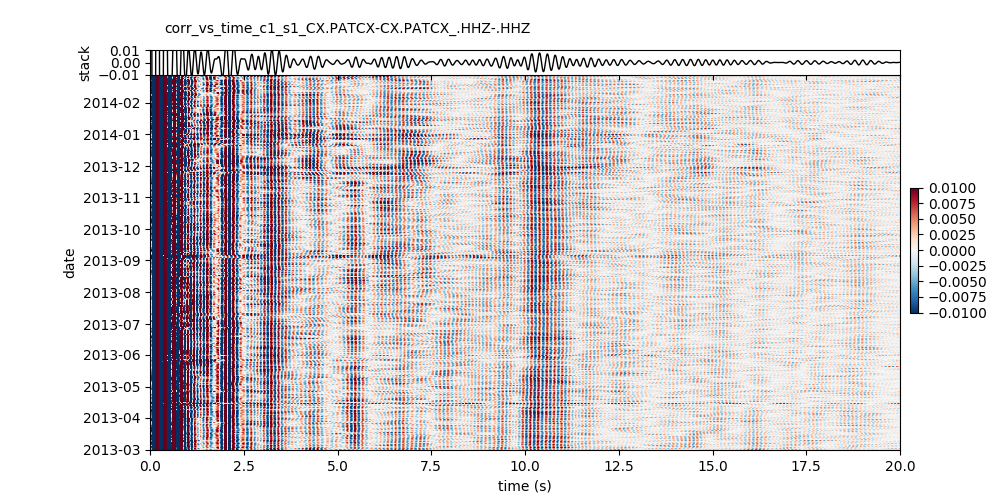

In [9]:
!yam plot c1_s1 --plot-options '{"trim": [0, 20], "vmax": 0.01}'
Image('plots/corr_vs_time_c1_s1_CX.PATCX-CX.PATCX_.HHZ-.HHZ.png')

We already see in this plot some distinct time shifts in the auto-correlations. Let's zoom in a bit to better observe this effect (on the "real" command line you can use the `--show` option to create an interactive figure).

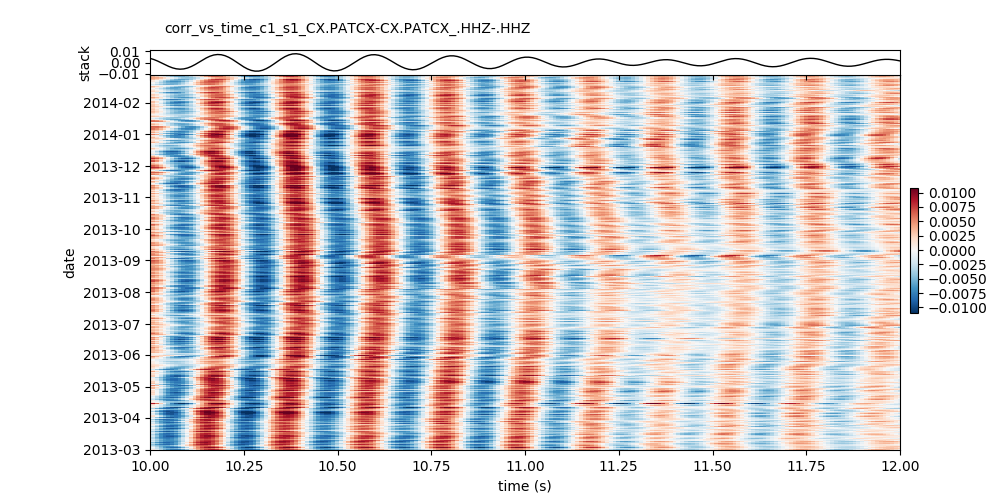

In [10]:
!yam plot c1_s1 --plot-options '{"trim": [10, 12]}'
Image('plots/corr_vs_time_c1_s1_CX.PATCX-CX.PATCX_.HHZ-.HHZ.png', width=800)

### Stretching and annual velocity changes

Let's stretch to quantify. The lag time windows defined are (5s, 10s), (10s, 15s) and (15s, 20s). But only the plot for 10s to 15s is displayed, here.

In [11]:
!yam stretch c1_s1 1

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.77s/it]


In [12]:
!yam info

Stations:
    CX.PATCX
    1 stations, 1 channels
Raw data (expression for day files):
    day_files/{network}.{station}.{location}.{channel}__{t.year}{t.month:02d}{t.day:02d}*.mseed
    365 files found
Config ids:
    c Corr: 1, 1b, 1c
    s Stack: 1
    t Stretch: 1
Correlations (channel combinations, correlations calculated):
    c1: 1 combs, 17512 corrs
Stacks:
    c1_s1: 1 combs, 728 corrs
Stretching matrices:
    c1_s1_t1: 1 combs


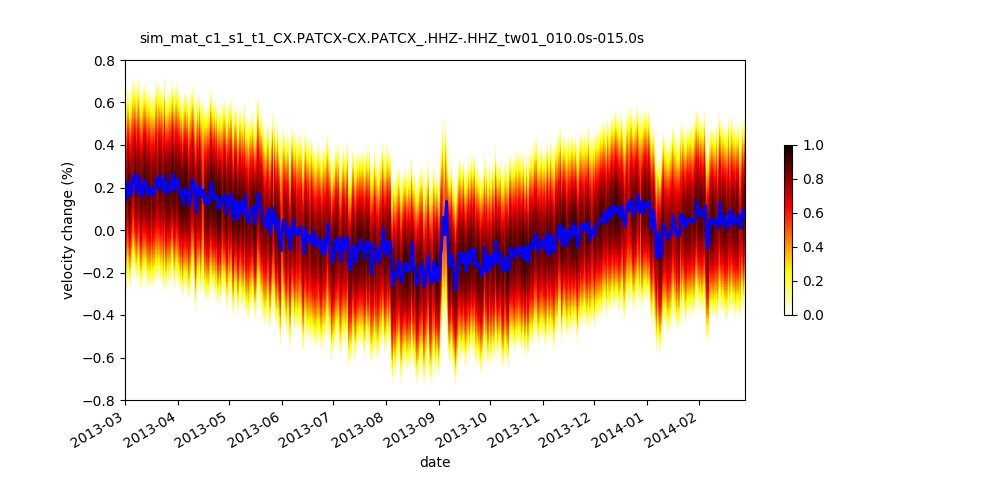

In [13]:
!yam plot c1_s1_t1 --plot-options '{"show_line": true, "vmax": 1, "ylim": 0.8}'
Image("plots/sim_mat_c1_s1_t1_CX.PATCX-CX.PATCX_.HHZ-.HHZ_tw01_010.0s-015.0s.png")

A pronounced seasonal effect is observed. Richter et al. show that this is due to changes in ground temperature in the course of the year. At the end of Chilean summer in March we observe the highest velocities and in September the lowest. The peak-to-peak amplitude of the annual velocity fluctuation is around 0.4%.

### Shaking induced velocity changes

Additional short-term velocity decreases with subsequent recovery are observed in the above plot.
We calculate the peak ground velocity (PGV) on the Z component for each day and plot these values together with the similarity matrix.

In [14]:
data = 'day_files/{network}.{station}.{location}.{channel}__{t.year}{t.month:02d}{t.day:02d}*.mseed'
inventory = read_inventory('CX.PATCX.xml')
days = list(IterTime(starttime, endtime))
pgvs = []
for day in tqdm.tqdm(days):
    datafile = data.format(network='CX', station='PATCX',
                           location='', channel='HHZ', t=day)
    try:
        stream = read(datafile)
    except:
        pgvs.append(None)
        continue
    stream.remove_sensitivity(inventory)
    stream.detrend()
    stream.filter('bandpass', freqmin=1, freqmax=30)
    pgv = 1e3 * max(np.abs(stream.max()))  # convert to mm/s
    pgvs.append(pgv)
pgvs = np.array(pgvs, dtype=float)

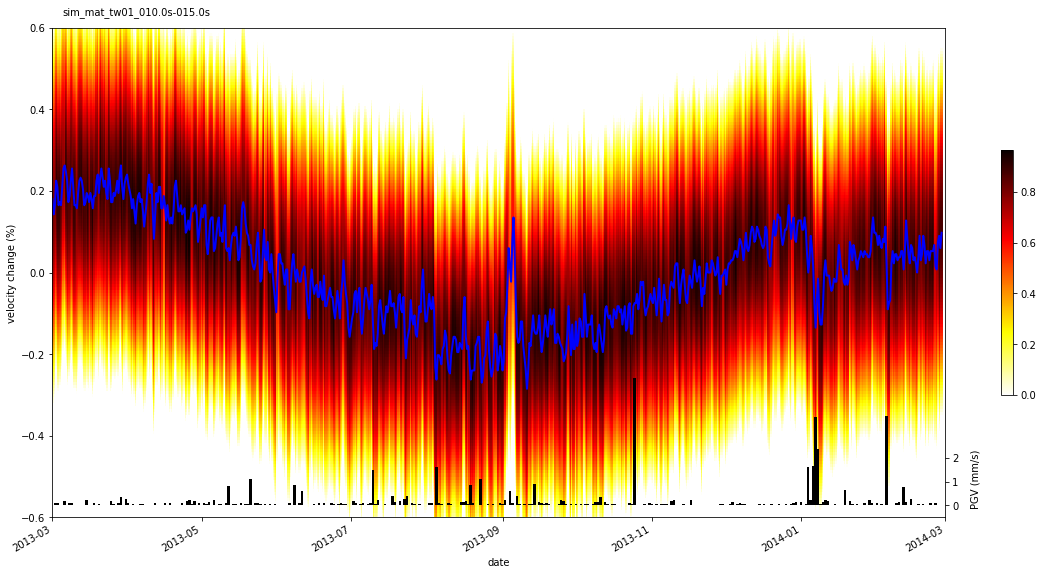

In [15]:
velchange = read_dicts('stretch.h5', 'c1_s1_t1')[0]
fig = plot_sim_mat(velchange, show_line=True, ylim=(-0.6, 0.6),
                   time_window=1, figsize=(20, 10))
ax = fig.axes[0]
ax2 = fig.add_axes(ax.get_position(True), sharex=ax, frameon=False)
ax2.xaxis.set_visible(False)
mpl_days = [day.matplotlib_date for day in days]
ax2.bar(mpl_days, pgvs, 1, color='k', lw=0)
ax2.set_ylim([-0.5, 20])
ax2.set_yticks([0, 1, 2])
ax2.yaxis.tick_right()
ax2.annotate('PGV (mm/s)', (mpl_days[-1], 2), (25, 0), 'data',
             'offset points', annotation_clip=False, rotation=90)
ax.set_xlim(mpl_days[0], mpl_days[-1])
plt.show()

Indeed, for most days with an observed high PGV we also observe a decrease in seismic velocity due to shaking (this can be better observed if you stretch the plot in x direction). Richter et al. find that the amplitude of the velocity decrease even better correlates to peak ground acceleration (PGA) than PGV, but we don't care here as we do not want to download all of the data of the accelerometer located right next to the seismometer. The apparent velocity increase observed in September 2013 is probably not "real", please also compare to the plot of correlations versus time above. Auto-correlations seem to deteriorate for this time period. Another strange observation is that for the highest observed PGV in October no equivalent velocity decrease can be observed. But it turns out that this high PGV is just an artifact in the data: 

Data of day with maximal observed PGV
/home/eule/anaconda/envs/workhorse/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


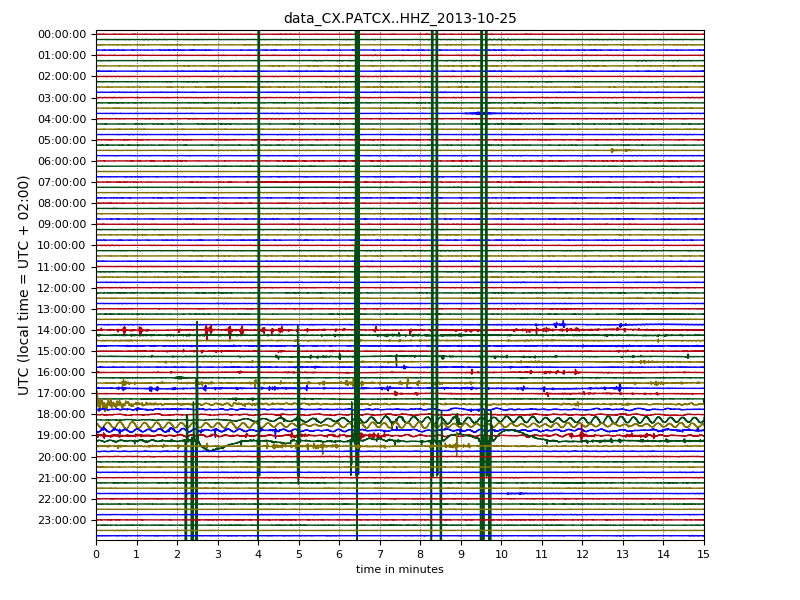

In [16]:
index_max_pgv = np.nanargmax(pgvs)
day_max_pgv = str(days[index_max_pgv])[:10]
print('Data of day with maximal observed PGV')
!yam plot data CX.PATCX..HHZ {day_max_pgv}
Image('plots/data_CX.PATCX..HHZ_%s.png' % day_max_pgv, width=600)

### Velocity changes in the daily course

Richter et al. also state that they observed daily velocity changes which we try to reproduce here.
First, the raw auto-correlations are plotted between 10s and 12s lag time, but not much can be observed here, except that there is sub-day "scatter". After that, two functions are defined. The first loads the correlation functions, selects them day-wise and performs the stretching for each day separately using the `yam.stretch.stretch` function. The second function averages all stretching values corresponding to the same time of the day and plots these means and the corresponding errors over the course of a representative day. We plot results for the first time window (5s to 10s).

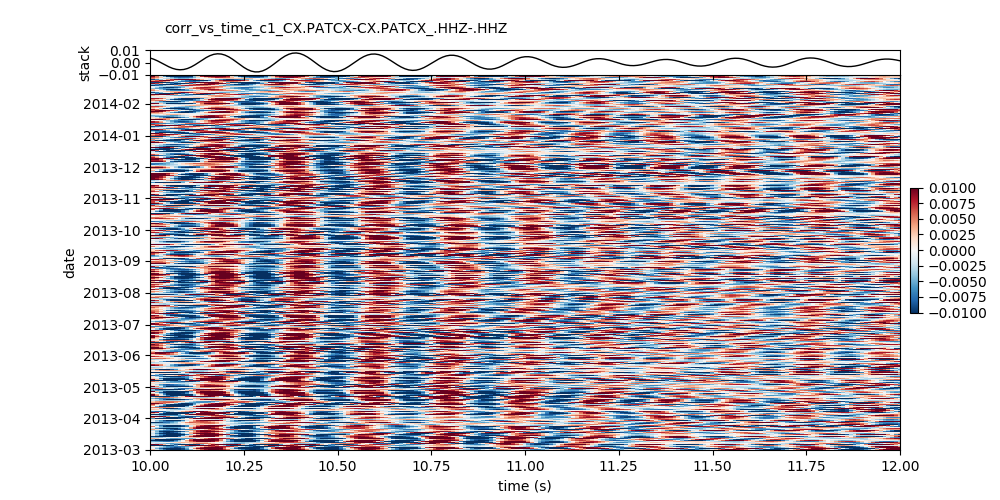

In [17]:
!yam plot c1 --plot-options '{"trim": [10, 12], "vmax": 0.01}'
Image('plots/corr_vs_time_c1_CX.PATCX-CX.PATCX_.HHZ-.HHZ.png', width=800)

In [18]:
def daily_vel_changes(group):
    corrs = read('corr.h5', 'H5', group=group)
    vc_list = []
    for day in tqdm.tqdm(IterTime(starttime, endtime)):
        selection = [s for s in corrs if s.stats.starttime >=
                     day and s.stats.starttime < day + 24 * 3600]
        if len(selection) != 48:
            continue
        res = stretch(Stream(selection).sort(), str_range=0.5,
                      nstr=201, time_windows=((5, 10, 15), 5))
        vc_list.append(res['velchange_vs_time'])
    vc = np.stack(vc_list)
    return vc


def plot_daily_vel_changes(vc, tw=0, label=None):
    vc_mean = np.mean(vc, axis=0)
    vc_err = 2 * np.std(vc, axis=0) / vc.shape[0] ** 0.5
    plt.errorbar(np.arange(48) / 2, vc_mean[:, tw], vc_err[:, tw], label=label)
    plt.xlabel('hours after UTC midnight')
    plt.ylabel('velocity change (%)')

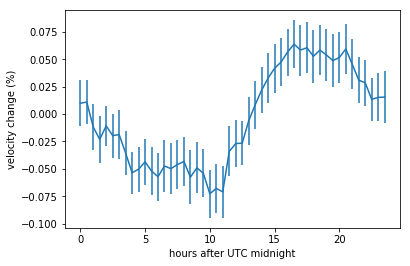

In [19]:
vc = daily_vel_changes('c1')
plt.figure()
plot_daily_vel_changes(vc)
plt.show()

The resulting figure pretty well reproduces figure 5 of Richter et al. and shows the velocity change in the course of one day. The amplitude of 0.07% is a bit lower than the 0.1% in the paper, but we also analyzed data of a shorter time period here. To not only reproduce already known things I will use the presented code to plot the same curve for auto-correlations of frequencies 2 Hz to 4 Hz and 6 Hz to 8 Hz. Therefore, we simply use the `"1b"` and `"1c"` configuration defined above. While no or a very low velocity change is observed for 2 Hz to 4Hz. The curve for 6 Hz to 8 Hz looks pretty similar to the blue curve above. This corresponds to the assumption that waves of lower frequency penetrate deeper into the ground and are therefore less sensitive to the daily near-surface velocity changes.

In [20]:
!yam correlate 1b
!yam correlate 1c

100%|█████████████████████████████████████████| 366/366 [12:15<00:00,  1.06s/it]


Velocity change meassured for 363 days in 48 time intervals per day.


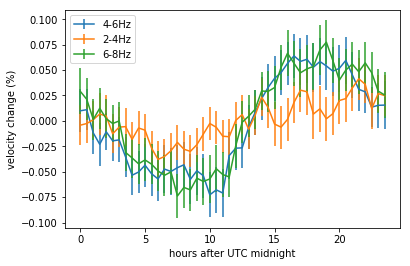

In [21]:
print('Velocity change meassured for %d days in %d time intervals per day.' %
      vc.shape[:2])

vc1b = daily_vel_changes('c1b')
vc1c = daily_vel_changes('c1c')

plt.figure()
plot_daily_vel_changes(vc, label='4-6Hz')
plot_daily_vel_changes(vc1b, label='2-4Hz')
plot_daily_vel_changes(vc1c, label='6-8Hz')
plt.legend()
plt.show()